# Spatio-Temporal Traffic Forecasting with Neural Graph Cellular Automata
Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Lucas Astore, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br


## Imports

In [1]:
import torch
from torch import nn


from st_nca.common import resume, get_device
from st_nca.datasets.PEMS import PEMS03
from st_nca.cellmodel import CellModel
from st_nca.gca import GraphCellularAutomata, timestamp_generator
from st_nca.finetune import FineTunningDataset, finetune_loop
from st_nca.evaluate import evaluate, diff_states

## Data

In [2]:
DEVICE = get_device()
DTYPE = torch.float32
DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'
MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

NTRANSF = 3
NHEADS = 16
NTRANSFF = 1024
TRANSFACT = nn.GELU()
MLP = 3
MLPD = 1024
MLPACT = nn.GELU()

ITERATIONS = 1

pems = PEMS03(device = DEVICE, dtype = DTYPE)


In [12]:
from st_nca.finetune import FineTunningDataset, finetune_loop

#ds = pems.get_allsensors_dataset(behavior='deterministic')

model = CellModel(num_tokens = pems.max_length, dim_token = pems.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

file = MODELS_PATH + 'h12_cell_model_{}_{}_{}_{}_{}.h5'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD)

#resume(cm, )

#resume(model, MODELS_PATH + 'UlGfLpFGDbWjtwcWVn59C_weights.h5')

model.load_state_dict(torch.load(file, 
                                 weights_only=True,
                                 map_location=torch.device(get_device())), strict=False)


gca = GraphCellularAutomata(device=DEVICE, dtype=DTYPE, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = model)

#finetune_ds = FineTunningDataset(pems, increment_type='minutes', increment=5, 
finetune_ds = FineTunningDataset(pems, increment_type='minutes', increment=5, 
                                 steps_ahead=12, step=250)

#X,_ = finetune_ds[0]
#y,_ = finetune_ds[1]

#p = gca.run_dict(X, ITERATIONS,increment_type='minute', increment=5)

#diff_states(y, p[0])

## Fine Tunning

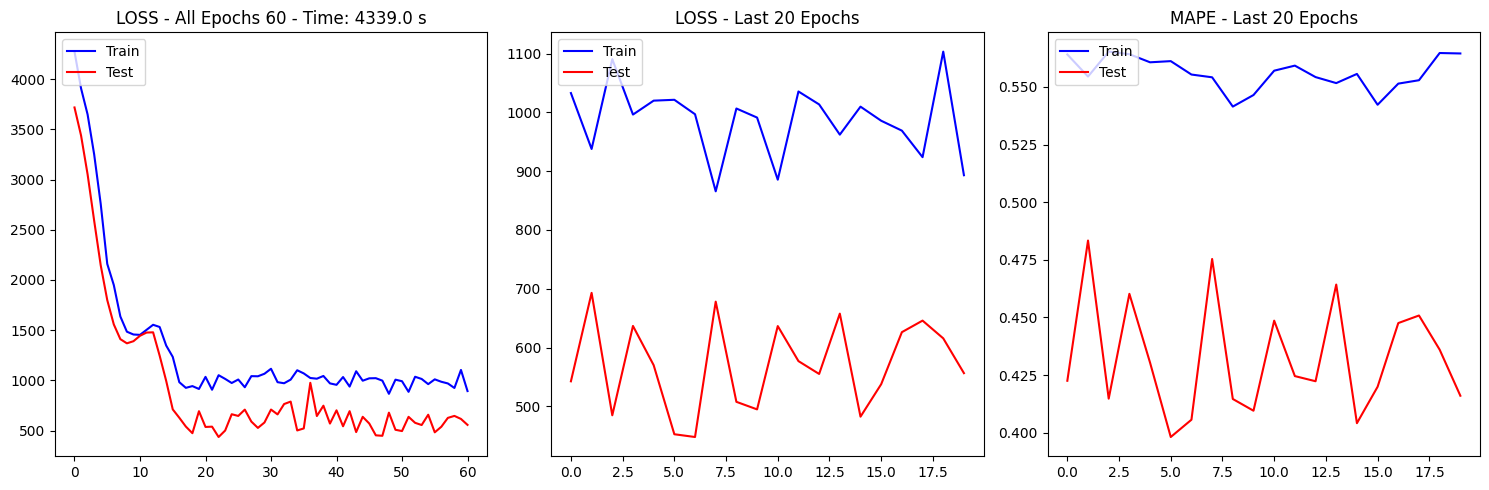

KeyboardInterrupt: 

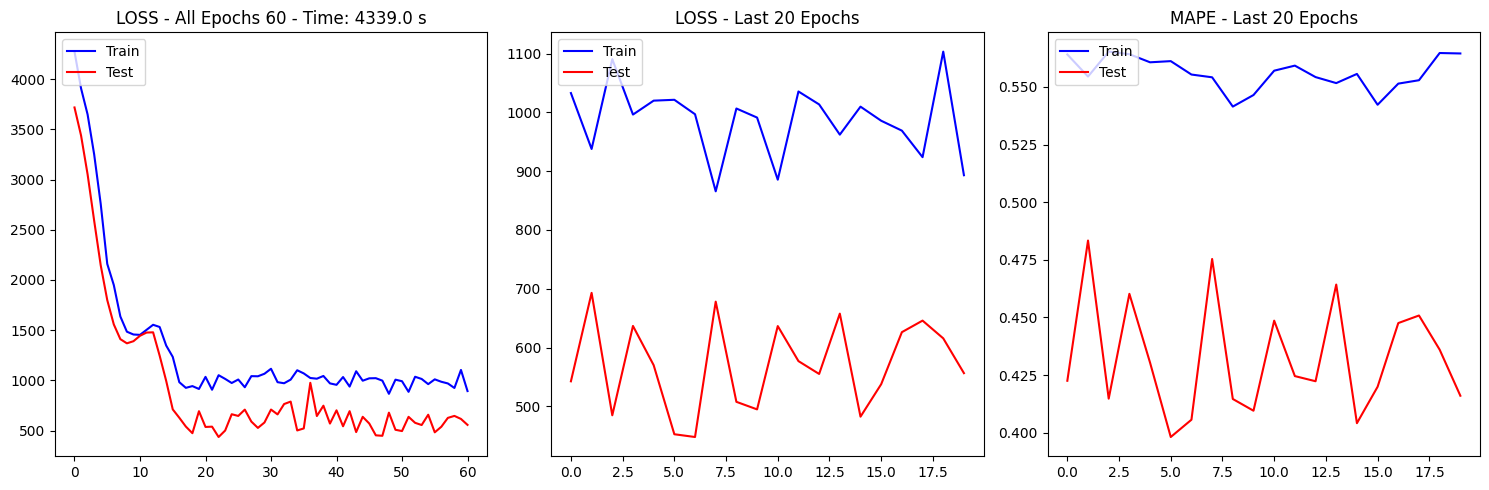

In [13]:
finetune_loop(DEVICE, finetune_ds, gca, 
#              iterations = ITERATIONS, increment_type='minutes', increment=5,
              iterations = 1, increment_type='hours', increment=1,
              epochs = 150, batch = 1, lr = 0.00001,
              checkpoint_file =  MODELS_PATH + 'h12_gca_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

## Evaluate

In [14]:
gca_file = MODELS_PATH + 'gca_{}_{}_{}_{}_{}.ptBEST'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD)

cell_model = CellModel(num_tokens = pems.max_length, dim_token = pems.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

gca = GraphCellularAutomata(device=DEVICE, dtype=DTYPE, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cell_model)


gca.load_state_dict(torch.load(gca_file, 
                                 weights_only=True,
                                 map_location=torch.device(get_device())), strict=False)

ITERATIONS = 12

dataset = FineTunningDataset(pems, increment_type='minutes', increment=5, 
                                 steps_ahead=ITERATIONS, step=10, device = DEVICE)


df = evaluate(dataset.test(), gca, ITERATIONS, increment_type='minutes', increment=5)
df

0
[datetime.datetime(2018, 9, 1, 1, 0), 0.6866655349731445, 41.859500885009766, 51.23065948486328, 0.8213792443275452]
1
[datetime.datetime(2018, 9, 1, 1, 5), 0.7037349343299866, 43.436283111572266, 53.395023345947266, 0.8707032203674316]
2
[datetime.datetime(2018, 9, 1, 1, 10), 0.7130796909332275, 43.38060760498047, 52.451290130615234, 0.8853164911270142]
3
[datetime.datetime(2018, 9, 1, 1, 15), 0.7199549078941345, 43.358158111572266, 51.90034866333008, 0.9045923352241516]
4
[datetime.datetime(2018, 9, 1, 1, 20), 0.7338556051254272, 42.92981719970703, 52.142276763916016, 0.9257097244262695]
5
[datetime.datetime(2018, 9, 1, 1, 25), 0.7686958909034729, 45.118125915527344, 53.33136749267578, 0.9908469915390015]
6
[datetime.datetime(2018, 9, 1, 1, 30), 0.7455646395683289, 44.03443908691406, 52.85710144042969, 0.9604528546333313]
7
[datetime.datetime(2018, 9, 1, 1, 35), 0.7608783841133118, 44.42843246459961, 53.176876068115234, 0.971886932849884]
8
[datetime.datetime(2018, 9, 1, 1, 40), 0.

KeyboardInterrupt: 

In [ ]:
DEVICE